In [724]:
import math
import random
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets  import make_blobs

from pathlib import Path

In [725]:
def accuracy_fn(Y_true,Y_predictions,p_out=False):
  correct = torch.eq(Y_true,Y_predictions).sum().item()
  accuracy = (correct / len(Y_predictions))
  
  if p_out: print(f"the accuracy is {accuracy*100:.5f}%")

  return accuracy

In [726]:
def training_loop(
        model,
        loss_fn,
        optimizer,
        train_features,
        train_labels,
        test_features,
        test_labels,
        epochs=100,
        manual_seed = 42,
        progress = 0,
        p_out = False
    ):
    # setting seeds - reproducability
    torch.manual_seed(manual_seed)
    torch.cuda.manual_seed(manual_seed)
    _step = epochs//10
    
    # setting loop
    for epoch in range(epochs):
        ###? train
        # turn on training mode
        model.train()

        # 1. forward pass
        train_logits = model(train_features).squeeze()
        train_probs = torch.sigmoid(train_logits)
        train_preds = torch.round(train_probs)

        # 2. calc the loss
        loss = loss_fn(train_logits,train_labels)
        acc = accuracy_fn(
            Y_true=train_labels,
            Y_predictions=train_preds
            )

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backwards (backpropagation)
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        ####? testing
        model.eval()
        with torch.inference_mode():
            # 1. forward pass
            test_logits = model(test_features).squeeze()
            test_probs = torch.sigmoid(test_logits)
            test_preds = torch.round(test_probs)

            # 2. calc the loss
            test_loss = loss_fn(test_logits,test_labels)
            test_acc = accuracy_fn(Y_true=test_labels,Y_predictions=test_preds)

        # print what's happening
        if epoch % _step == 0 and p_out:
            print(f'Epoch : {epoch} | Loss : {(loss):.5f}% | Acc : {(acc*100):.2f}% | Test loss : {(test_loss):.5f}% | Test acc : {(test_acc*100):.2f}%')
    progress += epochs
    print(progress)

In [727]:
# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# creating toy dataset
X_blob, y_blob = make_blobs( # type:ignore
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
    )
X_blob[:5],y_blob[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

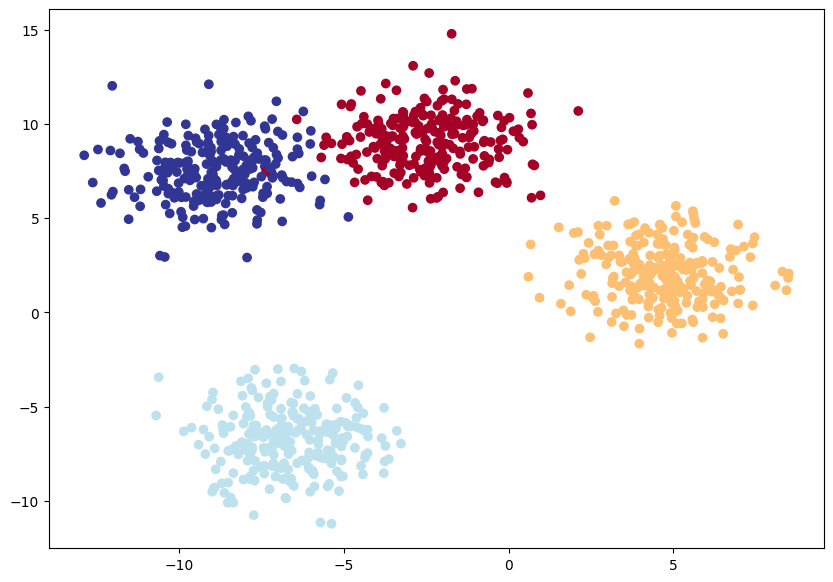

In [728]:
# split data into train-test datasets
X_train_blob,X_test_blob,y_train_blob,y_test_blob = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED,)

# plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=matplotlib.colormaps["RdYlBu"]) # type:ignore

In [729]:
# device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [730]:
class BlobModel_V0(nn.Module):
    def __init__(self,input_features,output_features,hidden_units = 8) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units,bias=True),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units,bias=True),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features,bias=True)
    )
    def forward(self,x):
        return self.linear_layer_stack(x)

In [731]:
model_0 = BlobModel_V0(2,4).to(device)
model_0

BlobModel_V0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [732]:
model_0.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.276

In [733]:
# create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr= 0.1
)

In [734]:
X_train_blob = torch.tensor(X_train_blob,dtype=torch.float).to(device)
X_test_blob = torch.tensor(X_test_blob,dtype=torch.float).to(device)
y_train_blob = torch.tensor(y_train_blob,dtype=torch.long).to(device)
y_test_blob = torch.tensor(y_test_blob,dtype=torch.long).to(device)


In [735]:
# prediction probabilities for multi class classification model
model_0.eval()
with torch.inference_mode():
    untrained_logits = model_0(X_train_blob).to(device)
    untrained_probabilities = torch.softmax(untrained_logits,dim=1)
    untrained_probabilities,untrained_predictions = torch.max(untrained_probabilities,dim=1)

# torch.unique(untrained_predictions),untrained_predictions
correct = torch.eq(untrained_predictions,y_train_blob)
acc = correct.sum()/len(untrained_predictions)

#? we can see that the average accuracy of the model is around 25% so its pretty much guessing between 4 options...
#? we must train the model and see if it yields more accurate results
acc

tensor(0.6550)

In [736]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 100
_step = epochs // 10 

for epoch in range(epochs):
    ### training
    model_0.train()

    #  1. forward pass
    train_logits = model_0(X_train_blob).to(device)
    train_predictions = torch.softmax(train_logits,dim=1).argmax(dim=1)

    # 2. calculate the loss
    loss = loss_fn(train_logits,y_train_blob)
    acc = accuracy_fn(Y_true=y_train_blob,Y_predictions=train_predictions)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test_blob).to(device)
        test_predictions = torch.softmax(test_logits,dim=1).argmax(dim=1)

        # 2. calculate the loss
        test_loss = loss_fn(test_logits,y_test_blob)
        test_acc = accuracy_fn(y_test_blob,test_predictions)
    # print whats happening
    if epoch % _step == 0 :
        print(f'Epoch : {epoch} | Loss : {(loss):.5f}% | Acc : {(acc*100):.2f}% | Test loss : {(test_loss):.5f}% | Test acc : {(test_acc*100):.2f}%')



Epoch : 0 | Loss : 1.04324% | Acc : 65.50% | Test loss : 0.48284% | Test acc : 75.00%
Epoch : 10 | Loss : 0.07344% | Acc : 97.88% | Test loss : 0.01596% | Test acc : 99.00%
Epoch : 20 | Loss : 0.04842% | Acc : 98.75% | Test loss : 0.00797% | Test acc : 100.00%
Epoch : 30 | Loss : 0.03250% | Acc : 99.00% | Test loss : 0.00363% | Test acc : 100.00%
Epoch : 40 | Loss : 0.02425% | Acc : 99.12% | Test loss : 0.00496% | Test acc : 100.00%
Epoch : 50 | Loss : 0.01924% | Acc : 99.50% | Test loss : 0.00886% | Test acc : 99.50%
Epoch : 60 | Loss : 0.01906% | Acc : 99.50% | Test loss : 0.00820% | Test acc : 100.00%
Epoch : 70 | Loss : 0.01837% | Acc : 99.38% | Test loss : 0.00635% | Test acc : 100.00%
Epoch : 80 | Loss : 0.01799% | Acc : 99.62% | Test loss : 0.00616% | Test acc : 100.00%
Epoch : 90 | Loss : 0.01766% | Acc : 99.38% | Test loss : 0.00578% | Test acc : 100.00%


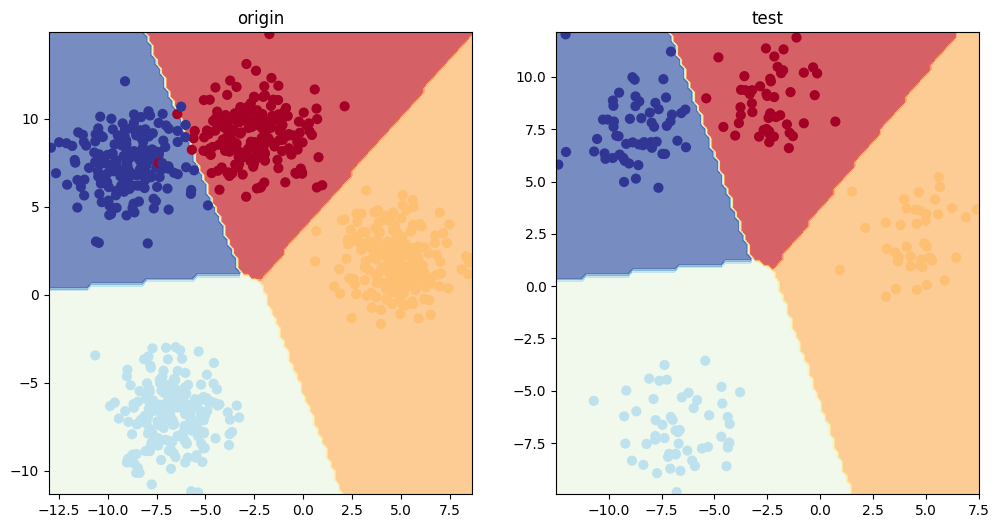

In [737]:
from helper_functions import plot_decision_boundary

# plot the data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("origin")
# plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=matplotlib.colormaps["bwr"]) # type:ignore
plot_decision_boundary(model_0,X_train_blob,y_train_blob)

plt.subplot(1,2,2)
plt.title("test")
# plt.scatter(X_test_blob[:,0],X_test_blob[:,1],c=test_predictions,cmap=matplotlib.colormaps["copper"]) # type:ignore
plot_decision_boundary(model_0,X_test_blob,y_test_blob)